In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from scipy.integrate import ode, odeint, solve_ivp
from scipy.optimize import minimize
from scipy.stats import dirichlet

# import DOE library
from doepy import build
from scipy.stats.qmc import Sobol
import itertools

params = {'legend.fontsize': 18,
          'figure.figsize': (7, 5),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'axes.linewidth':3,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.style.use('default')
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(1234) 

In [2]:
# function to generate consumer resource parameters 
# so that there are no feedback loops

def generate_params(n_r, n_s):
    
    # init consumer matrix
    C = np.zeros([n_r, n_s])    

    # assume all species depend heavily on one resource (e.g. glucose)
    C[0, :] = np.random.uniform(.05, .1, n_s)
    
    # assume some species depend weakly on other resources
    C[1:, :] = np.random.randint(0, 2, [n_r-1, n_s])*np.random.uniform(0, .05, [n_r-1, n_s])
        
    return C

In [3]:
# number of species 
n_s = 5
# having fewer resources causes resources (and species?) to deplete faster
n_r = 2

# define time steps to sample data
t_batch  = 160 # hr
t_samples =  8 # how many times to collect data
t_delta = t_batch // t_samples 
t_eval  = np.arange(0, t_batch+t_delta, t_delta)

# std. dev. of noise to add to data 
noise = .01

# efficiency of consumers
eps = .5

# generate consumer matrix 
C = generate_params(n_r, n_s)

# death rate of consumers 
d_s = 1/100 

# degradation rate of resources
d_r = 1/100

# full factorial of species abundances 
s_0s = np.array([np.array(i) for i in itertools.product([0, 1], repeat = n_s)])[1:] 

# random initial resource levels 
# r_0 = np.random.uniform(0, 2, n_r)
r_0 = np.array([2., 1.])

In [4]:
# define system of equations
def reactor(t, y):
    
    # y should never be negative
    y = np.clip(y, 0, np.inf)
    
    # species 
    s = y[:n_s]
    
    # resources
    r = y[n_s:]
    
    # rate of change of species 
    dsdt = s*(eps*C.T@r - d_s)

    # rate of change of resources (only positive elements of consumer matrix)
    drdt = -r*(C@s) 

    return np.append(dsdt, drdt)

In [5]:
# C_ij: rate that resource i is consumed by species j 
C

array([[0.05957597, 0.08110544, 0.07188639, 0.08926793, 0.08899879],
       [0.04075815, 0.00794077, 0.        , 0.        , 0.02434167]])

In [6]:
# initial set of species and resources and product
y_0 = np.append(.1*s_0s[-1], r_0)
y_0

array([0.1, 0.1, 0.1, 0.1, 0.1, 2. , 1. ])

In [7]:
t_batch

160

In [8]:
# define more time steps to sample data
t_eval = np.linspace(0, t_batch, 50)
soln = solve_ivp(reactor, (0, t_batch), y_0, 
                 t_eval=t_eval, method='LSODA')

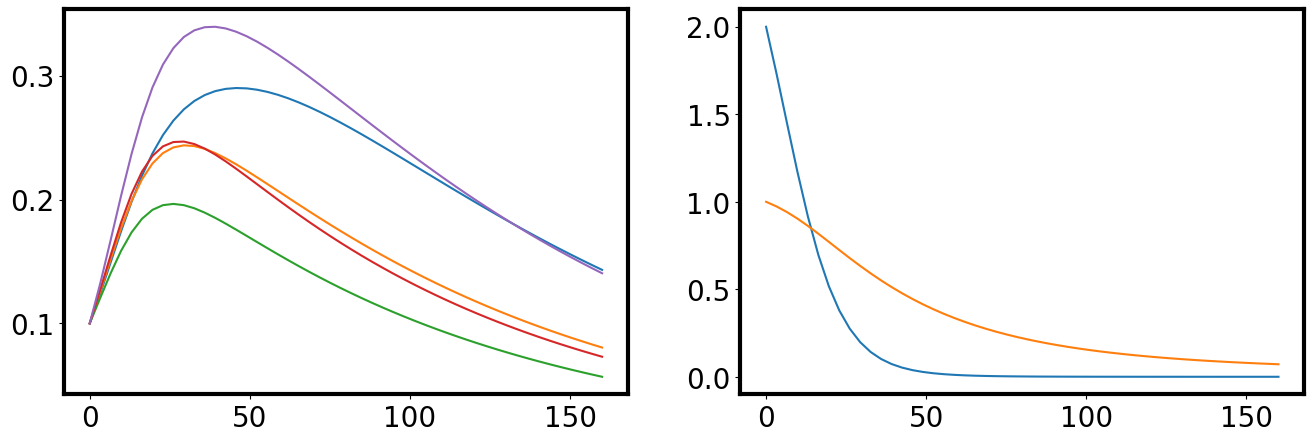

In [13]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(t_eval, soln.y[:n_s].T)

plt.subplot(1,2,2)
plt.plot(t_eval, soln.y[n_s:].T)
plt.show()

# Save to dataframe

In [10]:
# Data matrix with columns [Time, s1, ..., sn, r1, ..., rm, product]
D = np.zeros([len(t_eval)*s_0s.shape[0], 2+n_s])

# save exp names for feed condition 
exp_names = []

k = 0
for s_0 in s_0s:
    # set initial conditions
    IC = s_vals(s_0)
    y_0 = np.append(np.append(IC, r_vals(r_0)), 0.)
    
    # solve ode
    soln = solve_ivp(reactor, (0, t_batch), y_0, t_eval=t_eval, method='LSODA')
    
    # save species abundance and add noise
    y = soln.y.T[:, :n_s]
    y[1:] = y[1:] + noise*np.random.randn(y.shape[0]-1, y.shape[1])
    
    # make sure initially zero species stay zero regardless of noise
    y = np.einsum("j,ij-> ij", np.array(IC > 0, float), y)
    y = np.clip(y, 0, np.inf)

    # store data
    exp_names+= [f"Exp_{k}"]*len(t_eval)

    # store measurement times
    D[k*len(t_eval):(k+1)*len(t_eval), 0] = t_eval
    
    # store sum of OD
    D[k*len(t_eval):(k+1)*len(t_eval), 1] = np.sum(y, 1)
    
    # store species abundance, resource concentration, product concentration 
    D[k*len(t_eval):(k+1)*len(t_eval), 2:] = y

    # counter
    k+=1

# save dataframe
df = pd.DataFrame()
df['Experiments'] = exp_names
columns = ['Time'] + ["OD"] + ['s'+str(i+1) for i in range(n_s)]
for j,col in enumerate(columns):
    df[col] = D[:, j]

df.to_csv("CR_data_sum.csv", index=False)
df

NameError: name 's_vals' is not defined